# Topic Modeling on All-The-News Dataset. 
Source - [Kaggle - All the news](https://www.kaggle.com/snapcrack/all-the-news)

In this notebook, I applied Topic Modeling using LDA. I later labeled the Topics based on the Topic-Keyword Matrix and created a Multinomial Naive Bayes model to predict news categories.

I have only used the 'content' column as of now.

Do have a look!

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

pd.options.display.max_colwidth = 100

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Custom class to perform preprocessing
from utils import NLP

from collections import Counter
from datetime import datetime
%matplotlib inline

In [2]:
df1 = pd.read_csv('../Datasets/articles1.csv')
df2 = pd.read_csv('../Datasets/articles2.csv')
df3 = pd.read_csv('../Datasets/articles3.csv')
articles = pd.concat([df1,df2,df3])
del df1, df2, df3
articles.head()

Unnamed: 0     id  \
0           0  17283   
1           1  17284   
2           2  17285   
3           3  17286   
4           4  17287   

                                                                                         title  \
0             House Republicans Fret About Winning Their Health Care Suit - The New York Times   
1  Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times   
2         Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times   
3                         Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times   
4    Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times   

      publication                         author        date    year  month  \
0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

   url  \
0  NaN   
1  NaN   
2  NaN   
3  NaN   
4  NaN   

                                                                                               content  
0  WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care ...  
1  After the bullet shells get counted, the blood dries and the votive candles burn out, people pee...  
2  When Walt Disney’s “Bambi” opened in 1942, critics praised its spare, haunting visual style, vas...  
3  Death may be the great equalizer, but it isn’t necessarily evenhanded. Of all the fields of ende...  
4  SEOUL, South Korea  —   North Korea’s leader, Kim   said on Sunday that his country was making f...

In [8]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142570 entries, 0 to 42570
Data columns (total 10 columns):
Unnamed: 0     142570 non-null int64
id             142570 non-null int64
title          142568 non-null object
publication    142570 non-null object
author         126694 non-null object
date           139929 non-null object
year           139929 non-null float64
month          139929 non-null float64
url            85559 non-null object
content        142570 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 12.0+ MB


There are no missing values in the content column.

In [9]:
articles['title'].head()

0               House Republicans Fret About Winning Their Health Care Suit - The New York Times
1    Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times
2           Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times
3                           Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times
4      Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times
Name: title, dtype: object

In [10]:
articles['content'].head()

0    WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care ...
1    After the bullet shells get counted, the blood dries and the votive candles burn out, people pee...
2    When Walt Disney’s “Bambi” opened in 1942, critics praised its spare, haunting visual style, vas...
3    Death may be the great equalizer, but it isn’t necessarily evenhanded. Of all the fields of ende...
4    SEOUL, South Korea  —   North Korea’s leader, Kim   said on Sunday that his country was making f...
Name: content, dtype: object

In [11]:
articles['publication'].value_counts()

Breitbart              23781
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11114
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7179
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

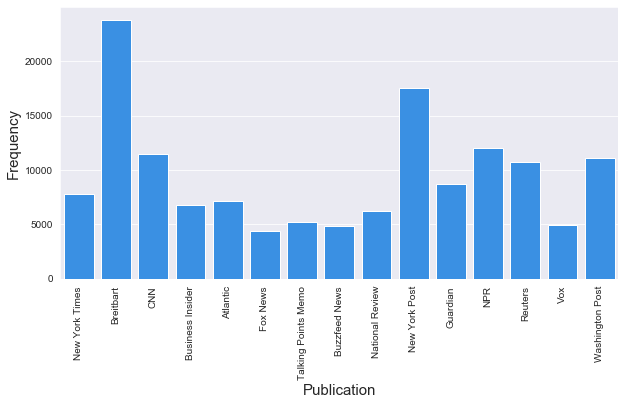

In [38]:
plt.figure(figsize=(10,5))
ax = sns.countplot(articles['publication'], color='dodgerblue')
ax.set_xlabel('Publication', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

**I have created a Class to perform basic Preprocessing(Tokenization, Lemmmatization, etc) using Gensim and Spacy libraries. This is done just for re-usability.**<br />
**We shall now tokenize our corpus using gensim. I used the gensim.simple_preprocess method which removes punctuations(deacc=True) and converts documents to lowercase**

In [3]:
docs = articles['content']
preprocess = NLP.PreprocessData(docs)

Tokenizing the documents...
Done.


In [4]:
tokens = preprocess.tokens

**Word Count Report:**

In [5]:
word_count = preprocess.word_count()
print("Average Word Count: {}".format(word_count['words_mean']))

Average Word Count: 698.9050641789997


In [6]:
print("Max Length: {}".format(word_count['words_max']))
print("Min Length: {}".format(word_count['words_min']))

Max Length: 47414
Min Length: 0


## Lemmatization using spacy
**I created a Spacy Object to perform Part of Speech Tagging.** <br />

In [7]:
lemmatized = preprocess.lemmatizer()

Lemmatizing...
Done.


**Finding the most frequently recurring words(excluded the stop words).**

In [46]:
word_count = Counter()
word_sent = [sentence.split() for sentence in lemmatized]
for word in word_sent:
    word_count += Counter(word)

In [47]:
stop_words = text.ENGLISH_STOP_WORDS

for ele in stop_words:
    del word_count[ele]
word_count.most_common()[:5]

[('say', 821228),
 ('trump', 290486),
 ('people', 253261),
 ('make', 235145),
 ('year', 232064)]

**Seems like the words "say" needs to be added to the stop words list. I will update this list later if needed.**

In [48]:
my_stop_words = ['say']

stop_words_updated = text.ENGLISH_STOP_WORDS.union(my_stop_words)

**We shall now Vectorize our corpus. I have set lowercase=False because it is already taken care of by gensim.simple_preprocess**

In [102]:
vectorizer = CountVectorizer(
    stop_words=stop_words_updated,
    lowercase=False,
    min_df=10,
    token_pattern='[a-zA-Z0-9]{3,}',
    ngram_range=(1,1)
)

In [103]:
vectorized_data = vectorizer.fit_transform(lemmatized)

In [104]:
vectorized_data.shape

(142570, 37199)

**Gridsearch to get the best parameters**

In [52]:
%%time
#No. of Topics Estimation Using Grid Search
params = {'n_components': [14, 16, 18], 'learning_decay': [0.7,.9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=params)

model.fit(vectorized_data)

a:\datascience\projects\environments\nlp-base\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 5h 20min 42s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [53]:
lda_model = model.best_estimator_

In [54]:
print("No. of components: {}".format(model.best_params_['n_components']))

No. of components: 16


In [55]:
print("Max Log Likelihood Score: {}".format(model.best_score_))

Max Log Likelihood Score: -105795106.51847856


## Document - Term Matrix

In [56]:
lda_output = lda_model.transform(vectorized_data)

df_document_topic = pd.DataFrame(np.round(lda_output,2), 
                                 columns=["Topic " + str(i) for i in range(model.best_params_['n_components'])],
                                 index=["Doc " + str(i) for i in range(vectorized_data.shape[0])]
                                )

dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic.head()

Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
Doc 0     0.00     0.00     0.55      0.0     0.00      0.0     0.00     0.36   
Doc 1     0.01     0.00     0.00      0.0     0.00      0.0     0.02     0.05   
Doc 2     0.00     0.08     0.00      0.0     0.00      0.2     0.00     0.02   
Doc 3     0.00     0.00     0.00      0.0     0.02      0.5     0.06     0.01   
Doc 4     0.00     0.00     0.00      0.0     0.00      0.0     0.00     0.03   

       Topic 8  Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  Topic 14  \
Doc 0     0.09     0.00      0.00      0.00      0.00      0.00      0.00   
Doc 1     0.00     0.04      0.04      0.69      0.06      0.01      0.07   
Doc 2     0.00     0.00      0.27      0.00      0.36      0.06      0.00   
Doc 3     0.00     0.00      0.00      0.03      0.35      0.00      0.00   
Doc 4     0.00     0.00      0.00      0.00      0.00      0.00      0.00   

       Topic 15  dominant_topic  
Doc 0      0.00               2  
Doc 1      0.00              11  
Doc 2      0.02              12  
Doc 3      0.03               5  
Doc 4      0.97              15

## Topic Distribution

In [57]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name='Number of Documents')
df_topic_distribution.columns = ['Topic', 'Number of Documents']

In [58]:
df_topic_distribution

Topic  Number of Documents
0       3                14299
1       8                13549
2      12                13042
3      11                12560
4       5                12465
5       7                10820
6      15                10447
7       0                10272
8      10                 8721
9       6                 6833
10     14                 6575
11      9                 5585
12      1                 5553
13      2                 5036
14     13                 3558
15      4                 3255

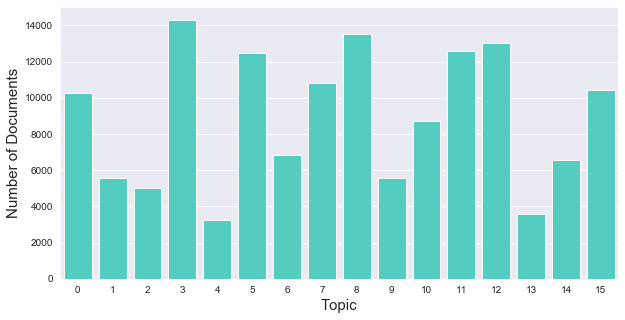

In [122]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(df_topic_distribution['Topic'], df_topic_distribution['Number of Documents'], color='turquoise')
ax.set_xlabel('Topic', fontsize=15)
ax.set_ylabel('Number of Documents', fontsize=15);

## Topic - Keyword Matrix <br/>
**The matrix generates keywords based on its weight, in descending order, for each topic.**

In [64]:
#Topic - Keyword Function
def map_keywords(vectorizer = vectorizer, lda_model = lda_model, words_to_disp = 10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for weights in lda_model.components_:
        topic_keyword_indices = (-weights).argsort()[:words_to_disp]
        topic_keywords.append(keywords.take(topic_keyword_indices))
    return topic_keywords

# Topic - Keywords Dataframe
topic_keywords = map_keywords(vectorizer=vectorizer, lda_model=lda_model, words_to_disp=10)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Word 0       Word 1         Word 2     Word 3    Word 4    Word 5  \
Topic 0    company     business           year        new       use      make   
Topic 1    country  immigration          order  immigrant   refugee    people   
Topic 2     people         plan         health       care       tax      make   
Topic 3      trump       medium           news  president    people      make   
Topic 4     flight        plane         report       tell    people    accord   
Topic 5       game         play           make       year      time      team   
Topic 6     people        black      political      white      vote      make   
Topic 7       case        court  investigation     report  official     email   
Topic 8      trump     campaign           vote  candidate       win  election   
Topic 9      study       people            use     health      drug     woman   
Topic 10     water         food           make       year    people      city   
Topic 11    police      officer            man       kill    people       gun   
Topic 12     woman         know         people      think      just      time   
Topic 13   student       school          state        law   college      year   
Topic 14   percent         year           rate     market       job     trade   
Topic 15  military       attack     government      force   country       war   

              Word 6      Word 7      Word 8        Word 9  
Topic 0         sell        sale     include          firm  
Topic 1          law  government      border           ban  
Topic 2          pay   insurance        work         think  
Topic 3     campaign     twitter       think          just  
Topic 4       travel   passenger    official           fly  
Topic 5          win        just        good        season  
Topic 6        right       party     country      american  
Topic 7     attorney  government         law   information  
Topic 8   republican       voter       state  presidential  
Topic 9         year     patient    research        doctor  
Topic 10        just        home        time           use  
Topic 11        tell      report      attack        arrest  
Topic 12        life        make        want          work  
Topic 13   education      public  university         group  
Topic 14     economy    economic        high        worker  
Topic 15    official       state       group          isis

**Creating Topic Dictionary based on the keywords.**

In [66]:
topic_dict = {
    0: 'Business',
    1: 'Immigrants',
    2: 'Healthcare',
    3: 'Elections',
    4: 'Travel',
    5: 'Sports',
    6: 'Racism/Human Rights',
    7: 'Judiciary',
    8: 'Elections',
    9: 'Healthcare',
    10: 'People/Lifestyle',
    11: 'Crime',
    12: 'People/Lifestyle',
    13: 'Education',
    14: 'Economy',
    15: 'Military/Government'
}

**We shall now include Topic and TopicID(Will be useful to create the model).**

In [80]:
articles['Topic'] = pd.Series(dominant_topic).replace(topic_dict)

In [81]:
articles.drop('Unnamed: 0', axis=1, inplace=True)

In [82]:
articles['TopicID'] = dominant_topic

In [83]:
articles.head()

id  \
0  17283   
1  17284   
2  17285   
3  17286   
4  17287   

                                                                                         title  \
0             House Republicans Fret About Winning Their Health Care Suit - The New York Times   
1  Rift Between Officers and Residents as Killings Persist in South Bronx - The New York Times   
2         Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times   
3                         Among Deaths in 2016, a Heavy Toll in Pop Music - The New York Times   
4    Kim Jong-un Says North Korea Is Preparing to Test Long-Range Missile - The New York Times   

      publication                         author        date    year  month  \
0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

   url  \
0  NaN   
1  NaN   
2  NaN   
3  NaN   
4  NaN   

                                                                                               content  \
0  WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care ...   
1  After the bullet shells get counted, the blood dries and the votive candles burn out, people pee...   
2  When Walt Disney’s “Bambi” opened in 1942, critics praised its spare, haunting visual style, vas...   
3  Death may be the great equalizer, but it isn’t necessarily evenhanded. Of all the fields of ende...   
4  SEOUL, South Korea  —   North Korea’s leader, Kim   said on Sunday that his country was making f...   

                 Topic  TopicID  
0           Healthcare        2  
1                Crime       11  
2     People/Lifestyle       12  
3               Sports        5  
4  Military/Government       15

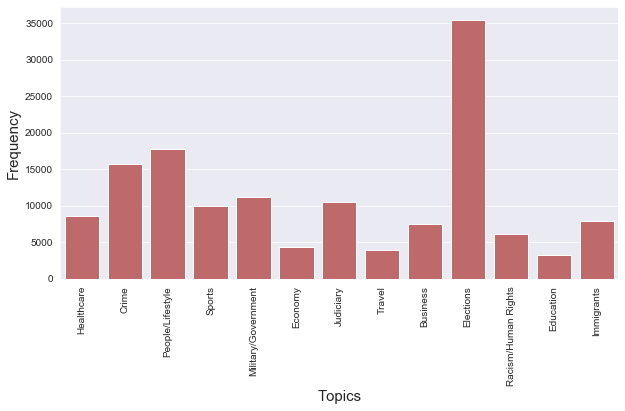

In [127]:
plt.figure(figsize=(10,5))
ax = sns.countplot(articles['Topic'], color='indianred')
ax.set_xlabel('Topics', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

**Train-Test-Split**

In [106]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_data, articles['TopicID'], test_size=0.25)

**Multinomial Naive Bayes**

In [107]:
supervised_model_mnb = MultinomialNB()
supervised_model_mnb.fit(X_train, y_train)
predictions = supervised_model_mnb.predict(X_test)
accuracy_score(y_test, predictions)

0.8739163370086693

**Logistic Regression with Newton Conjugate-Gradient Optimization**

In [108]:
supervised_model_lr = LogisticRegression(solver='newton-cg')
supervised_model_lr.fit(X_train, y_train)
predictions = supervised_model_lr.predict(X_test)
accuracy_score(y_test, predictions)

a:\datascience\projects\environments\nlp-base\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8615716971074264

**Seems like our Naive Bayes model outperforms Logistic Regression.** <br/><br/>
**We shall now test our data with news from the web. I have taken two news content from bbc.com to test the model.**

In [109]:
def preprocess_array(texts_array):
    preprocess = NLP.PreprocessData(text_array)
    return preprocess.lemmatizer()

In [110]:
string1 = 'There\'s plenty of analysis of Tuesday night\'s televised debate between Prime Minister Boris Johnson and Labour leader Jeremy Corbyn in the papers. Paul Waugh, for HuffPost UK, suggests Mr Johnson "undeniably had the best of the first half of the debate, when it was focused on Brexit". He finds that there was "no knockout blow" in "this political boxing match", but that Mr Corbyn "won several rounds on points". A similar analogy is employed by the Daily Mail, which concludes that Mr Johnson "kept [Mr Corbyn] on the ropes". Its columnist, Henry Deedes, believes "the judges\' scorecards would have edged the prime minister", who, he says, delivered "an assured performance". Corbyn v Johnson fact-checked How did the election debate play out online? Five things from the debate For Quentin Letts in The Times, the event was "unexpectedly good sport" - "pacy, a little chaotic", with an audience that "deployed forced, supportive, mocking, occasionally disbelieving laughter as a weapon of attrition". He declares the moderator, ITV\'s Julie Etchingham, the "clear winner".'

**string1**

There's plenty of analysis of Tuesday night's televised debate between Prime Minister Boris Johnson and Labour leader Jeremy Corbyn in the papers. Paul Waugh, for HuffPost UK, suggests Mr Johnson "undeniably had the best of the first half of the debate, when it was focused on Brexit". He finds that there was "no knockout blow" in "this political boxing match", but that Mr Corbyn "won several rounds on points". A similar analogy is employed by the Daily Mail, which concludes that Mr Johnson "kept [Mr Corbyn] on the ropes". Its columnist, Henry Deedes, believes "the judges' scorecards would have edged the prime minister", who, he says, delivered "an assured performance". Corbyn v Johnson fact-checked How did the election debate play out online? Five things from the debate For Quentin Letts in The Times, the event was "unexpectedly good sport" - "pacy, a little chaotic", with an audience that "deployed forced, supportive, mocking, occasionally disbelieving laughter as a weapon of attrition". He declares the moderator, ITV's Julie Etchingham, the "clear winner".

In [111]:
string2 = 'The announcement came as it suspended its dividend and reported a loss in the first half of its financial year.De La Rue said its warning was based on a worst-case scenario.However, it concluded that there was "a material uncertainty that casts significant doubt on the group\'s ability to operate as a going concern".UK-based De La Rue prints produces cash for about 140 central banks and employs more than 2,500 people globally.'

**string2**

The announcement came as it suspended its dividend and reported a loss in the first half of its financial year.De La Rue said its warning was based on a worst-case scenario.However, it concluded that there was "a material uncertainty that casts significant doubt on the group's ability to operate as a going concern".UK-based De La Rue prints produces cash for about 140 central banks and employs more than 2,500 people globally.

In [112]:
string_list = np.array([string1, string2])
prediction = supervised_model_mnb.predict(vectorizer.transform(preprocess_array(string_list)))
for index in range(len(string_list)):
    print(topic_dict[prediction[index]])

Elections
Economy


## Observations
1. The model did fairly well in giving the dominant topic for each document.
2. GridSearch took a considerable amount of time (5 hours approx), which is obvious, keeping the size of the courpus in mind.
3. The MultinomialNB model outperformed Logisitic Regression. 
4. The two random news articles picked from bbc.com were correctly classified.

## Future Scope
I didn't spend much time on improvising the Supervised model as LDA/Topic Modeling was of interest here. I will update this notebook as frequently as possible though.

Feedback and Suggestions are Welcome!

# Thank You!